In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import timm  # For MobileViT models

E:\3uTools\anaconda\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# Normalization values
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# Data preparation
data_dir = 'E:\DATA SETS\split_dataset'  # Replace with your dataset directory


# Unified preprocessing pipeline
common_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Apply the same to all splits
data_transforms = {
    'train': common_transform,
    'val': common_transform,
    'test': common_transform,
}


In [3]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Grape___Esca_(Black_Measles)', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___healthy']


In [9]:
print(f"Number of training images: {len(image_datasets['train'])}")
print(f"Number of validation images: {len(image_datasets['val'])}")
print(f"Number of testing images: {len(image_datasets['test'])}")

Number of training images: 12821
Number of validation images: 3660
Number of testing images: 1844


In [6]:
!pip install --upgrade timm


   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ----------------- ---------------------- 1.0/2.4 MB 3.1 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.4 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------  2.4/2.4 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 2.8 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.14
    Uninstalling timm-1.0.14:
      Successfully uninstalled timm-1.0.14



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
print([m for m in timm.list_models() if "mobilevit" in m])

['mobilevit_s', 'mobilevit_xs', 'mobilevit_xxs', 'mobilevitv2_050', 'mobilevitv2_075', 'mobilevitv2_100', 'mobilevitv2_125', 'mobilevitv2_150', 'mobilevitv2_175', 'mobilevitv2_200']


In [4]:
# Load MobileViT model
model = timm.create_model('mobilevit_xxs', pretrained=True)
model.reset_classifier(num_classes=len(class_names))
model = model.to(device)

In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [6]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}\n{"-" * 10}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Train
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.0910 Acc: 0.7338
val Loss: 0.1324 Acc: 0.9579
Epoch 1/19
----------
train Loss: 0.3219 Acc: 0.9216
val Loss: 0.0729 Acc: 0.9784
Epoch 2/19
----------
train Loss: 0.1947 Acc: 0.9532
val Loss: 0.0436 Acc: 0.9866
Epoch 3/19
----------
train Loss: 0.1321 Acc: 0.9680
val Loss: 0.0501 Acc: 0.9866
Epoch 4/19
----------
train Loss: 0.1057 Acc: 0.9730
val Loss: 0.0673 Acc: 0.9822
Epoch 5/19
----------
train Loss: 0.0591 Acc: 0.9866
val Loss: 0.0257 Acc: 0.9956
Epoch 6/19
----------
train Loss: 0.0461 Acc: 0.9902
val Loss: 0.0256 Acc: 0.9945
Epoch 7/19
----------
train Loss: 0.0366 Acc: 0.9923
val Loss: 0.0258 Acc: 0.9943
Epoch 8/19
----------
train Loss: 0.0339 Acc: 0.9930
val Loss: 0.0276 Acc: 0.9937
Epoch 9/19
----------
train Loss: 0.0341 Acc: 0.9927
val Loss: 0.0258 Acc: 0.9951
Epoch 10/19
----------
train Loss: 0.0260 Acc: 0.9955
val Loss: 0.0267 Acc: 0.9948
Epoch 11/19
----------
train Loss: 0.0252 Acc: 0.9951
val Loss: 0.0250 Acc: 0.9956
Epoch 12/19
--


Classification Report:

                               precision    recall  f1-score   support

           Apple___Apple_scab       1.00      1.00      1.00        63
            Apple___Black_rot       1.00      0.98      0.99        63
     Apple___Cedar_apple_rust       1.00      1.00      1.00        28
              Apple___healthy       0.99      1.00      1.00       165
 Grape___Esca_(Black_Measles)       1.00      1.00      1.00       139
Pepper,_bell___Bacterial_spot       1.00      1.00      1.00       101
       Pepper,_bell___healthy       1.00      1.00      1.00       149
        Potato___Early_blight       1.00      0.99      0.99       100
         Potato___Late_blight       0.97      0.99      0.98       100
             Potato___healthy       1.00      1.00      1.00        16
     Strawberry___Leaf_scorch       1.00      1.00      1.00       112
         Strawberry___healthy       1.00      1.00      1.00        46
      Tomato___Bacterial_spot       1.00      1.00 

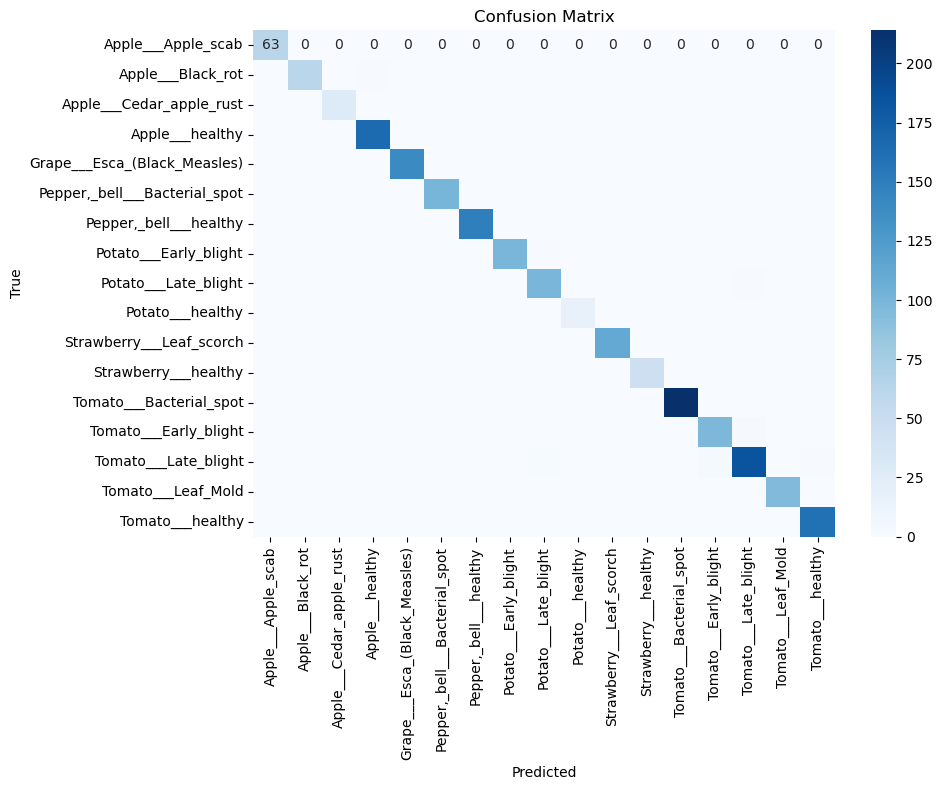

In [11]:
# Test evaluation
def evaluate_model(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Metrics
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Evaluate on test set
evaluate_model(model, dataloaders['test'], class_names)

In [12]:
FILE = r'E:\DATA SETS\MobileViT_Dataset\best_mobilevit17.pth'
torch.save(model.state_dict(), FILE)


In [13]:
# Save model weights
torch.save(model.state_dict(), r'E:\DATA SETS\MobileViT_Dataset\best_mobilevit17.pth')


In [14]:
# Later, load weights into model (after model is instantiated)
model.load_state_dict(torch.load(r'E:\DATA SETS\MobileViT_Dataset\best_mobilevit17.pth'))
model.eval()

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (shortcut): Identity()
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
          

In [ ]:
import torch
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

# ---- Configurations ----
model_name = 'mobilevit_xxs'
num_classes = 17
model_weights_path = r'E:/DATA SETS/MobileViT_Dataset/best_mobilevit17.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = [
    "Apple___Apple_scab", 
    "Apple___Black_rot", 
    "Apple___Cedar_apple_rust", 
    "Apple___healthy", 
    "Grape___Esca_(Black_Measles)", 
    "Pepper,_bell___Bacterial_spot", 
    "Pepper,_bell___healthy", 
    "Potato___Early_blight", 
    "Potato___Late_blight", 
    "Potato___healthy", 
    "Strawberry___Leaf_scorch", 
    "Strawberry___healthy", 
    "Tomato___Bacterial_spot", 
    "Tomato___Early_blight", 
    "Tomato___Late_blight", 
    "Tomato___Leaf_Mold", 
    "Tomato___healthy"
]

# ---- Step 1: Rebuild model ----
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.to(device)
model.eval()

# ---- Step 2: Define preprocessing ----
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25))  # Adjust if you used different normalization
])

# ---- Step 3: Load image ----
image_path = r'E:\Grad Project Crop Disease\test images\potatolateblight.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# ---- Step 4: Inference ----
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = F.softmax(outputs, dim=1)
    confidence, predicted_class = torch.max(probabilities, 1)

# ---- Step 5: Show prediction ----
plt.imshow(image)
plt.axis('off')
pred_label = class_names[predicted_class.item()]
plt.title(f'Prediction: {pred_label} | Confidence: {confidence.item()*100:.2f}%')
plt.show()


E:\3uTools\anaconda\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:

import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

# Load the model
model = timm.create_model(model_name='mobilevit_xxs', pretrained=False, num_classes=17)
model.load_state_dict(torch.load('E:/DATA SETS/MobileViT_Dataset/best_mobilevit17.pth', map_location=torch.device('cpu')))
model.eval()

# Convert to TorchScript
scripted_model = torch.jit.script(model)

# Save as .pt
scripted_model.save("mobilevit_model17.pt")
